# Training a CFFQNN with the Iris Dataset using Exact Statevectors

Near-term quantum hardware is subject to noise, meaning gate and measurement errors are likely and qubits cannot hold their states for long periods of time. Because of this, quantum algorithms can be inconsistent and unpredictable. However, it can be beneficial to simulate quantum algorithms without noise so that we can evaluate the theoretical advantages of quantum technology.

Here, I will simulate a CFFQNN without noise using Qiskit.


In [3]:
from qiskit import qpy, QuantumCircuit
import numpy as np

## Import Dataset


In [4]:
x_train = np.load("../datasets/iris/iris_train_x.npy")
y_train = np.load("../datasets/iris/iris_train_y.npy")

## Import CFFQNN


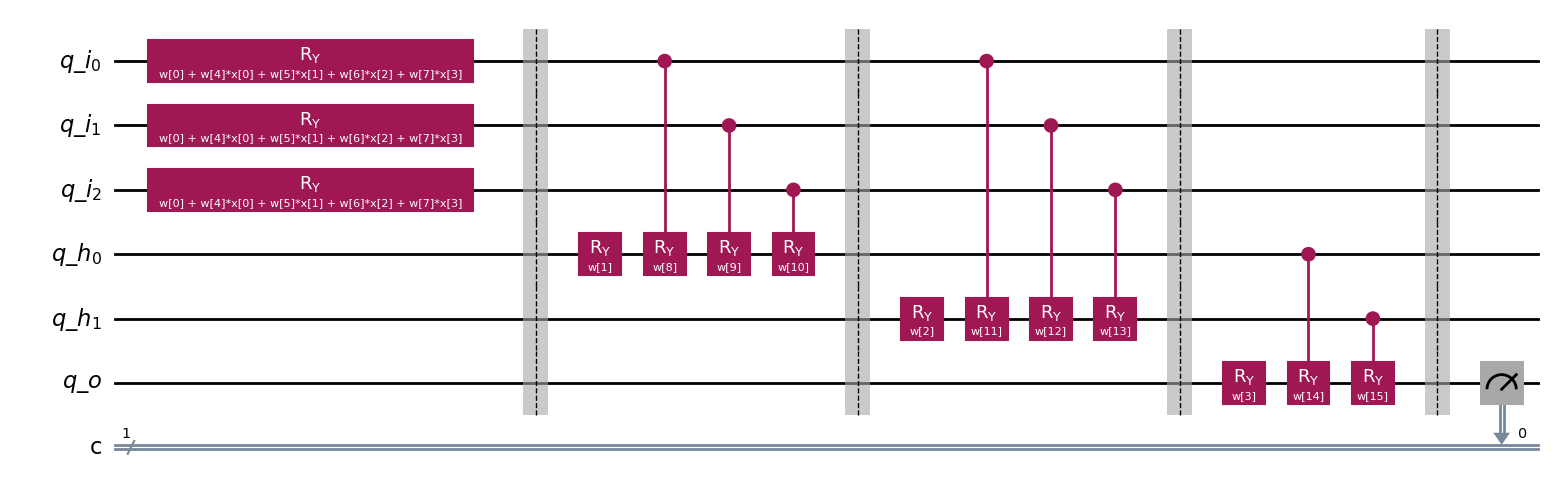

In [5]:
with open("../models/cffqnn.qpy", "rb") as f:
    qc = qpy.load(f)[0]

qc.draw(output='mpl')

## Prepare Circuit for Training

The CFFQNN will be trained against a cost function using the expectation value of the measured qubit as the output.


In [6]:
# Removes final measurement to get expectation 
# values instead of binary measurement outcomes
qc.remove_final_measurements(inplace=True)

# Creates dict containing each QuantumRegister
qregs = {reg.name: reg for reg in qc.qregs}

# Output register
q_o = qregs["q_o"]

# Global index of output qubit
out_index = qc.find_bit(q_o[0]).index

## Recover Parameters


In [7]:
# Extract all Parameter objects
all_params = list(qc.parameters)

# Split by name prefix, then sort by integer index inside brackets
def sorted_by_index(params, prefix):
    items = [p for p in params if p.name.startswith(prefix)]
    # Default index 0 if no brackets
    def idx(p):
        name = p.name
        if "[" in name and "]" in name:
            return int(name.split("[", 1)[1].split("]", 1)[0])
        return 0
    return sorted(items, key=idx)

x_params = sorted_by_index(all_params, 'x')
w_params = sorted_by_index(all_params, 'w')

## Forward Pass

First, this function binds the QNN's parameters to actual values. These bindings are then assigned to the `QuantumCircuit`. Then, the expectation value for the final qubit is calculated and used as the output of the CFFQNN.


In [8]:
from qiskit.quantum_info import Statevector, Pauli

def forward(x_values, w_values):
    # Build a binding dictionary
    bind = {}
    bind.update(dict(zip(x_params, np.asarray(x_values, dtype=float))))
    bind.update(dict(zip(w_params, np.asarray(w_values, dtype=float))))

    bound = qc.assign_parameters(bind)

    # Exact statevector and expectation
    sv = Statevector.from_instruction(bound)

    # Returns value in [-1,1] corresponding to expectation
    # value on observable (Pauli-Z)
    z_exp = sv.expectation_value(Pauli("Z"), [out_index]).real
    return z_exp

## Cost Function

The Mean Squared Error (MSE) function will be used to compute the loss.


In [9]:
def mse(X, y, w):
    # y in {0,1}; map to z_targets in {+1, -1}
    z_targets = 1.0 - 2.0 * np.asarray(y, dtype=float)

    # Predict output over all inputs
    preds = np.array([forward(x, w) for x in X], dtype=float)

    # Return MSE
    return float(np.mean((preds - z_targets)**2))

## Training Cycle

The COBYLA function will be used to update the CFFQNN's weights since it is gradient-free.

The weights will be initialized randomly from a normal distribution. There may be more optimal weight initialization functions.


In [10]:
from scipy.optimize import minimize

# Initialize Weights
rng = np.random.default_rng(7)
w0 = rng.normal(0, 0.1, size=len(w_params))

# Optimize
res = minimize(lambda w: mse(x_train, y_train, w),
               x0=w0, method="COBYLA",
               options=dict(maxiter=300, rhobeg=0.2, tol=1e-6, disp=True))

w_trained = res.x
print("Final loss: ", mse(x_train, y_train, w_trained))

Return from COBYLA because the objective function has been evaluated MAXFUN times.
Number of function values = 300   Least value of F = 0.2560781483638887
The corresponding X is:
[-0.61612197 -0.34307172  0.59930613  0.61088189 -0.28366334 -0.62803795
  0.7471052   1.18647049 -0.82073605 -1.21977032 -0.95982345 -0.38571916
 -0.01254231 -0.31635888  1.9247956  -0.09165701]

Final loss:  0.2560781483638887


## Testing

I will now test the trained weights to determine if the model can accurately predict the type of flower given its measurements.


In [11]:
def predict_prob(X, w):
    # returns probability of class 1
    preds_z = np.array([forward(xi, w) for xi in X], dtype=float)
    return (1.0 - preds_z) / 2.0

def predict_label(X, w, threshold = 0.5):
    p1 = predict_prob(X, w)
    return (p1 >= threshold).astype(int)

x_test = np.load("../datasets/iris/iris_test_x.npy")
y_test = np.load("../datasets/iris/iris_test_y.npy")

y_hat = predict_label(x_test, w_trained)
print("predictions:", np.array(list(zip(y_hat, y_test))))
print("accuracy: ", float(np.mean(y_hat == y_test)))

predictions: [[1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [1 0]
 [1 1]
 [0 0]
 [1 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]]
accuracy:  0.9


## Noisy Testing


In [12]:
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

noise_model = NoiseModel()

p = 0.01
error_1q = depolarizing_error(p, 1)
error_2q = depolarizing_error(p, 2)

noise_model.add_all_qubit_quantum_error(error_1q, ["ry"])
noise_model.add_all_qubit_quantum_error(error_2q, ["cry"])

backend = AerSimulator(noise_model=noise_model)
